TODO for script cleanup:
- Siminspiral_T_over_M + Convertion on it's own in Freq_Amp_method must be merged
- Invalid value encounter

In [1]:
# from generating_waveforms import SimInspiral
import lalsimulation as lalsim
import lal
import pycbc
from pycbc import waveform
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda
from timeit import default_timer as timer
from sklearn import preprocessing
from numba.core.errors import NumbaDeprecationWarning, NumbaWarning
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

# plt.switch_backend('WebAgg')
%matplotlib inline

%config IPCompleter.greedy=True

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


# Generating waveforms

In [2]:
def SimInspiral(total_mass, mass_ratio, eccmin, freqmin, inclination = 0., DeltaT = 1./2048., lalDict = lal.CreateDict()):
    mass1 = total_mass/((1/mass_ratio) + 1)
    mass2 = total_mass - mass1
    
    hp, hc = lalsim.SimInspiralTD(m1 = lal.MSUN_SI*mass1, m2 = lal.MSUN_SI*mass2, 
                              S1x = 0., S1y = 0., S1z = 0., 
                              S2x = 0., S2y = 0., S2z = 0.,
                              distance = (400.*1e6*lal.PC_SI), inclination = inclination,
                              phiRef = 0., longAscNodes = 0, eccentricity = eccmin, meanPerAno = 0.,
                              deltaT = DeltaT, f_min = freqmin, f_ref = freqmin,
                              LALparams = lalDict, approximant = lalsim.EccentricTD)

    hp_TS = pycbc.types.timeseries.TimeSeries(hp.data.data, delta_t=hp.deltaT)
    hc_TS = pycbc.types.timeseries.TimeSeries(hc.data.data, delta_t=hc.deltaT)

    hp_times = -hp_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass )
    hc_times = -hc_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

    return hp_TS, hc_TS



# Finding apocenters and pericenters

In [212]:
def get_peaks_t_over_M(values):

    valuesmin = -values
    pericenters_index, _per = find_peaks(values, height=0)
    apocenters_index, _apo = find_peaks(valuesmin, height=-100)

    pericenters = _per['peak_heights']
    apocenters = -_apo['peak_heights']

    return pericenters_index, pericenters, apocenters_index, apocenters


In [18]:
def get_freq_amp_wf(total_mass, mass_ratio, eccmin, freqmin):
    hp_TS, hc_TS, hp_times, hc_times = SimInspiral(total_mass, mass_ratio, eccmin, freqmin)
    
    # Frequency and amplitude of eccentric waveform
    amp = waveform.utils.amplitude_from_polarizations(hp_TS, hc_TS)
    freq = waveform.utils.frequency_from_polarizations(hp_TS, hc_TS) * 2*np.pi * (lal.MTSUN_SI * total_mass )

    # Convert time units from [s] to [M]
    amp_times = -amp.sample_times[::-1] / (lal.MTSUN_SI * total_mass )
    freq_times = -freq.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

    return hp_TS, hp_times, amp, amp_times, freq, freq_times

In [230]:
def Freq_Amp_Method(total_mass, mass_ratio, eccmin, freqmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    # AMPLITUDE AND FREQUENCY METHOD

    # Get waveform amplitude and frequency
    hp_TS, hp_times, amp, amp_times, freq, freq_times = get_freq_amp_wf(total_mass, mass_ratio, eccmin, freqmin)

    # Determine apocenters and pericenters
    amp_pericenters_index, amp_pericenters, amp_apocenters_index, amp_apocenters = get_peaks_t_over_M(amp)
    freq_pericenters_index, freq_pericenters, freq_apocenters_index, freq_apocenters = get_peaks_t_over_M(freq)

    amp_times_p, amp_times_a = amp_times[amp_pericenters_index], amp_times[amp_apocenters_index]
    freq_times_p, freq_times_a = freq_times[freq_pericenters_index], freq_times[freq_apocenters_index]

    return freq_times_a, freq_apocenters, freq_times_p, freq_pericenters, amp_times_a, amp_apocenters, amp_times_p, amp_pericenters, freq, amp, freq_times, amp_times

def Plot_Freq_Amp_method(total_mass, mass_ratio, eccmin, freqmin):
    
    freq_times_a, freq_apocenters, freq_times_p, freq_pericenters, amp_times_a, amp_apocenters, amp_times_p, amp_pericenters, freq, amp, freq_times, amp_times = Freq_Amp_Method(total_mass, mass_ratio, eccmin, freqmin)
    
    fig_Freq_Amp, axs = plt.subplots(3, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)

    axs[0].plot(hp_times, hp_TS)
    axs[0].set_ylabel('h$_{+}$')
    # plt.xlim(-7, 0)
    axs[0].set_xlabel('t [M]')
    axs[0].set_title('Waveform; total mass={}, mass ratio={}, eccmin={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin))


    axs[1].plot(amp_times, amp, color='orange')
    axs[1].scatter(amp_times_p, amp_pericenters, color='blue', s=5 , label='pericenters')
    axs[1].scatter(amp_times_a, amp_apocenters, color='magenta', s=5 , label='apocenters')
    axs[1].set_ylabel('A$_+$')
    axs[1].set_xlim(-20000, 0)
    # axs[1].set_ylim(0, 50)
    axs[1].set_xlabel('t [M]')
    axs[1].legend(loc='upper left')
    axs[1].set_title('Amplitude Method')


    axs[2].plot(freq_times, freq, color='orange')
    axs[2].scatter(freq_times_p, freq_pericenters, color='blue', s=5 , label='pericenters')
    axs[2].scatter(freq_times_a, freq_apocenters, color='magenta', s=5 , label='apocenters')
    axs[2].set_ylabel('f$_+$ = $\omega_+$/2$\pi$ [rad/M]')
    axs[2].set_xlim(-20000, 0)
    axs[2].set_ylim(0, 0.2)
    axs[2].set_xlabel('t [M]')
    axs[2].legend(loc='upper left')
    axs[2].set_title('Frequency Method')

    plt.show()
    # figname = 'Apocenters_Epicenters_FrequencyMethod_zoom.png'
    # fig1.savefig('Images/' + figname)


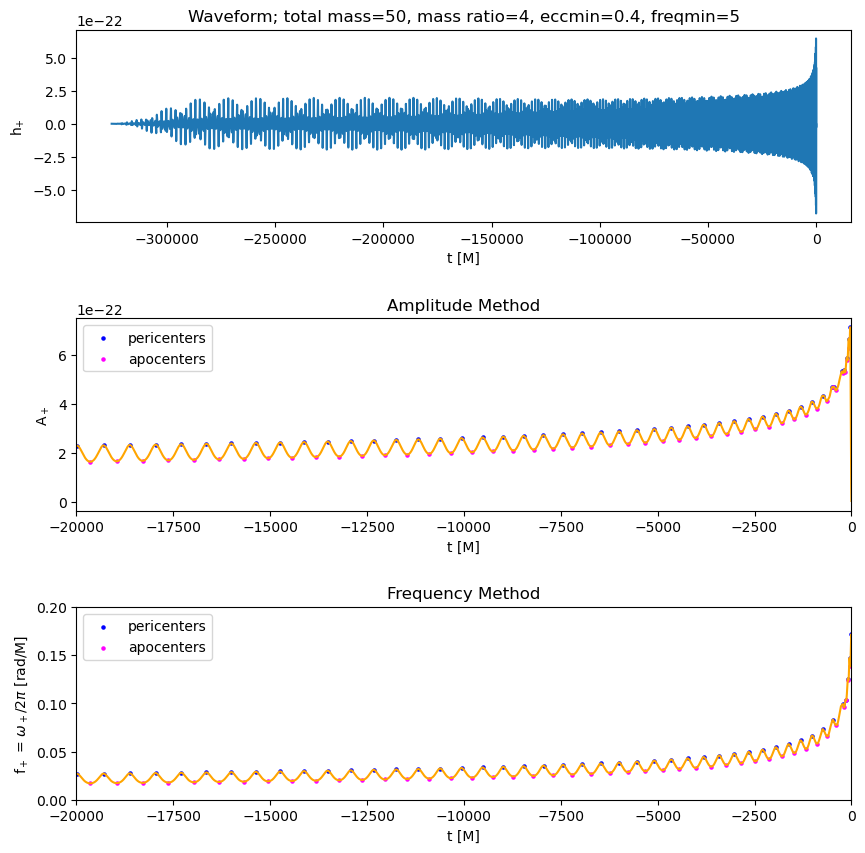

In [231]:
Plot_Freq_Amp_method(50, 4, 0.4, 5)

In [245]:

def Residual_Freq_Amp_Method(total_mass, mass_ratio, eccmin, freqmin):
    #RESIDUAL AMPLITUDE AND FREQUENCY METHOD
    
    # Eccentric waveform amplitude and frequency
    hp_TS, hp_times, amp, amp_times, freq, freq_times = get_freq_amp_wf(total_mass, mass_ratio, eccmin, freqmin)
    
    # Circulair waveform amplitude and frequency
    hp_TS_circ, hp_times_circ, amp_circ, amp_times_circ, freq_circ, freq_times_circ = get_freq_amp_wf(total_mass, mass_ratio, 1e-10, freqmin)

    amp_circ = amp_circ[len(amp_circ) - len(amp):]
    freq_circ = freq_circ[len(freq_circ) - len(freq):]


    
    # Residual frequency 
    res_freq = np.zeros(len(freq))

    for i in range(len(freq_times)):
        res_freq[i] = freq[i] - freq_circ[i]

    res_freq_pericenters_index, res_freq_pericenters, res_freq_apocenters_index, res_freq_apocenters = get_peaks_t_over_M(res_freq)


    # Residual Amplitude
    res_amp = np.zeros(len(amp))

    for i in range(len(amp_times)):
        res_amp[i] = amp[i] - amp_circ[i]

    res_amp_pericenters_index, res_amp_pericenters, res_amp_apocenters_index, res_amp_apocenters = get_peaks_t_over_M(res_amp)

    
    
    # Circulair waveform
    fig_wf_ecc0 = plt.figure(figsize=(10, 2))
    
    plt.plot(hp_times_circ, hp_TS_circ)
    plt.ylabel('h$_{+}$')
    plt.xlim(-50000, 0)
    plt.xlabel('t [M]')
    plt.title('Waveform; total mass={}, mass ratio={}, eccmin={}, freqmin={}'.format(total_mass, mass_ratio, 0, freqmin))

    
    # Difference frequecy and amplitude of eccentric and circulair waveform
    fig_ecc0, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1]})
    plt.subplots_adjust(hspace=0.4)

    fig_ecc0.suptitle('Difference for ecc=0')

    axs[0][0].plot(freq_times, freq, label = 'e = {}'.format(eccmin), color='orange')
    axs[0][0].plot(freq_times, freq_circ, label = 'e = 0.0', color='blue')
    axs[0][0].set_ylabel('f$_+$ [rad/M]')
    axs[0][0].set_xlim(-20000, 0)
    axs[0][0].set_ylim(0, 0.15)
    axs[0][0].set_xlabel('t [M]')
    axs[0][0].legend(loc='upper left')

    axs[0][1].plot(freq_times, freq, label = 'e = {}'.format(eccmin), color='orange')
    axs[0][1].plot(freq_times, freq_circ, label = 'e = 0.0', color='blue')
    # axs[0][1].set_ylabel('f$_+$ [rad/M]')
    axs[0][1].set_xlim(-1000, 0)
    axs[0][1].set_ylim(0, 0.15)
    axs[0][1].set_xlabel('t [M]')

    # axs[1].plot(amp_times, amp, label='A$_+$', color='orange' )
    # axs[1].plot(amp_times, amp_circ, label='A$_+^{circ}$', color='red')
    axs[1][0].plot(amp_times, amp, label='e = {}'.format(eccmin), color='orange')
    axs[1][0].plot(amp_times, amp_circ, label='e = 0.0', color='blue')
    axs[1][0].set_ylabel('A$_+$')
    axs[1][0].set_xlabel('t [M]')
    axs[1][0].set_xlim(-20000, 0)
    axs[1][0].legend(loc='upper left')

    axs[1][1].plot(amp_times, amp, label='e = {}'.format(eccmin), color='orange')
    axs[1][1].plot(amp_times, amp_circ, label='e = 0.0', color='blue')
    # axs[1][1].set_ylabel('A$_+$')
    axs[1][1].set_xlabel('t [M]')
    axs[1][1].set_xlim(-1000, 0)
    axs[1][1].set_xticks([])


    
    # Residual frequency and amplitude 
    fig2, axs = plt.subplots(3, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)

    axs[0].plot(hp_times, hp_TS)
    axs[0].set_ylabel('h$_{+}$')
    # axs.xlim(-7, 0)
    axs[0].set_xlabel('t [M]')
    axs[0].set_title('Waveform; total mass={}, mass ratio={}, eccmin={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin))

    # axs[1].plot(amp_times, amp, label='A$_+$', color='orange' )
    # axs[1].plot(amp_times, amp_circ, label='A$_+^{circ}$', color='red')
    axs[1].plot(amp_times, res_amp, label='Residual Amplitude', color='orange')
    axs[1].scatter(amp_times[res_amp_pericenters_index], res_amp_pericenters, color='blue', s=5 , label='pericenters')
    axs[1].scatter(amp_times[res_amp_apocenters_index], res_amp_apocenters, color='magenta', s=5 , label='apocenters')
    axs[1].set_ylabel('$\Delta$A$_+$ [rad/M]')
    axs[1].set_xlim(-20000, -2500)
    axs[1].set_ylim(-0.5e-22, 0.5e-22)
    axs[1].set_xlabel('t [M]')
    axs[1].legend(loc='upper left')
    axs[1].set_title('Residual amplitude Method')

    # axs[2].plot(freq_times, freq, label='$\omega_+$', color='orange')
    # axs[2].plot(freq_times, freq_circ, label='$\omega_+^{circ}$', color='red')
    axs[2].plot(freq_times, res_freq, label = 'Residual frequency', color='orange')
    axs[2].scatter(freq_times[res_freq_pericenters_index], res_freq_pericenters, color='blue', s=5 , label='pericenters')
    axs[2].scatter(freq_times[res_freq_apocenters_index], res_freq_apocenters, color='magenta', s=5 , label='apocenters')
    axs[2].set_ylabel('$\Delta$f$_+$ = $\Delta\omega_+$/2$\pi$ [Hz]')
    axs[2].set_xlim(-20000, -2500)
    axs[2].set_ylim(-0.5e-1, 0.5e-1)
    axs[2].set_xlabel('t [M]')
    axs[2].legend(loc='upper left')
    axs[2].set_title('Residual frequency Method')

    # figname = 'Residual_Amp_Freq_over_M_zoom.png'
    # fig2.savefig('Images/' + figname)

    return freq_times[res_freq_apocenters_index], res_freq_apocenters, freq_times[res_freq_pericenters_index], res_freq_pericenters, amp_times[res_amp_apocenters_index], res_amp_apocenters, amp_times[res_amp_pericenters_index], res_amp_pericenters, res_freq, res_amp

plt.show()

(array([-3.64168221e+05, -3.62896834e+05, -3.60772898e+05, -3.58418477e+05,
        -3.56088839e+05, -3.53774071e+05, -3.51469217e+05, -3.49171798e+05,
        -3.46881814e+05, -3.44601743e+05, -3.42326628e+05, -3.40058949e+05,
        -3.37798705e+05, -3.35545896e+05, -3.33300521e+05, -3.31060104e+05,
        -3.28827121e+05, -3.26601574e+05, -3.24383461e+05, -3.22172784e+05,
        -3.19967063e+05, -3.17768777e+05, -3.15577927e+05, -3.13394511e+05,
        -3.11218530e+05, -3.09047506e+05, -3.06883917e+05, -3.04727763e+05,
        -3.02576566e+05, -3.00432803e+05, -2.98296476e+05, -2.96167584e+05,
        -2.94046126e+05, -2.91929626e+05, -2.89820560e+05, -2.87716451e+05,
        -2.85622256e+05, -2.83533017e+05, -2.81451213e+05, -2.79376844e+05,
        -2.77307432e+05, -2.75245454e+05, -2.73190912e+05, -2.71141327e+05,
        -2.69099176e+05, -2.67064461e+05, -2.65037180e+05, -2.63014857e+05,
        -2.61002446e+05, -2.58992514e+05, -2.56992495e+05, -2.54997433e+05,
        -2.5

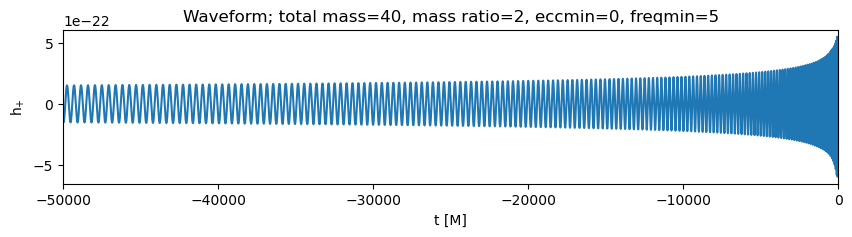

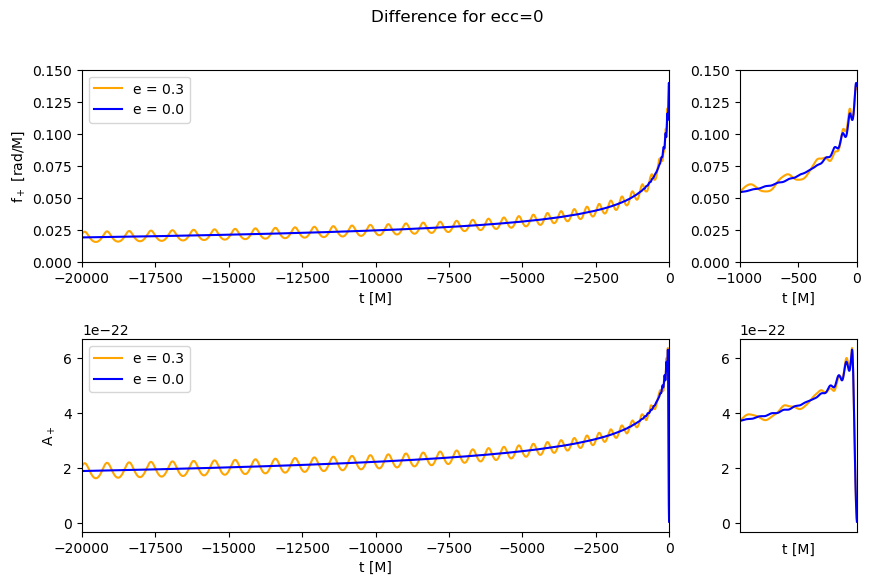

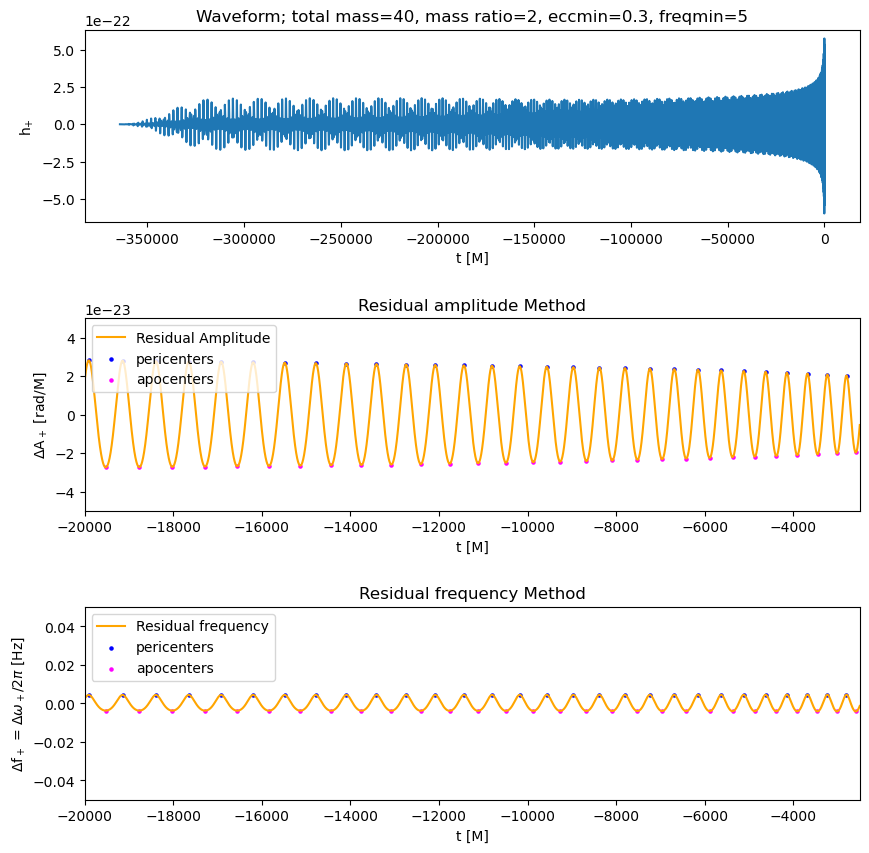

In [246]:
Residual_Freq_Amp_Method(40, 2, 0.3, 5)

(array([-4.03242441e+05, -4.02839959e+05, -4.02377997e+05, -4.00581697e+05,
        -3.98706091e+05, -3.96832468e+05, -3.94964792e+05, -3.93099099e+05,
        -3.91237372e+05, -3.89377627e+05, -3.87521847e+05, -3.85670033e+05,
        -3.83820202e+05, -3.81974336e+05, -3.80130452e+05, -3.78290534e+05,
        -3.76454581e+05, -3.74620611e+05, -3.72790607e+05, -3.70962584e+05,
        -3.69138528e+05, -3.67318436e+05, -3.65500328e+05, -3.63686184e+05,
        -3.61874023e+05, -3.60065828e+05, -3.58261598e+05, -3.56459351e+05,
        -3.54661069e+05, -3.52864769e+05, -3.51072435e+05, -3.49284067e+05,
        -3.47497681e+05, -3.45715260e+05, -3.43936805e+05, -3.42160332e+05,
        -3.40385842e+05, -3.38617300e+05, -3.36850741e+05, -3.35088147e+05,
        -3.33327535e+05, -3.31570889e+05, -3.29818209e+05, -3.28067511e+05,
        -3.26320778e+05, -3.24576028e+05, -3.22835244e+05, -3.21098424e+05,
        -3.19365571e+05, -3.17634699e+05, -3.15907793e+05, -3.14182870e+05,
        -3.1

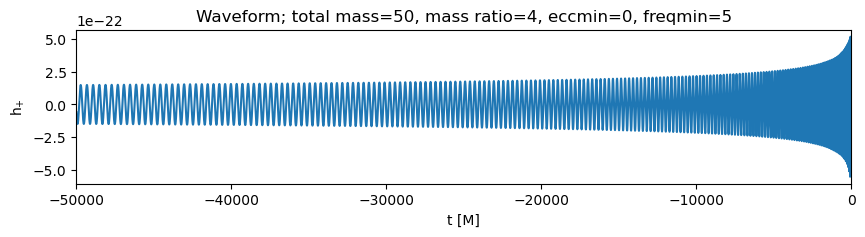

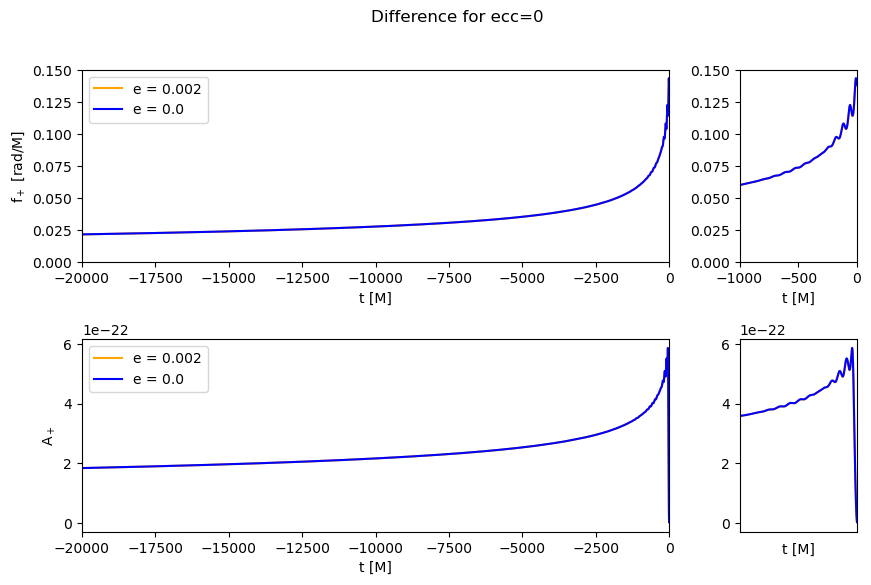

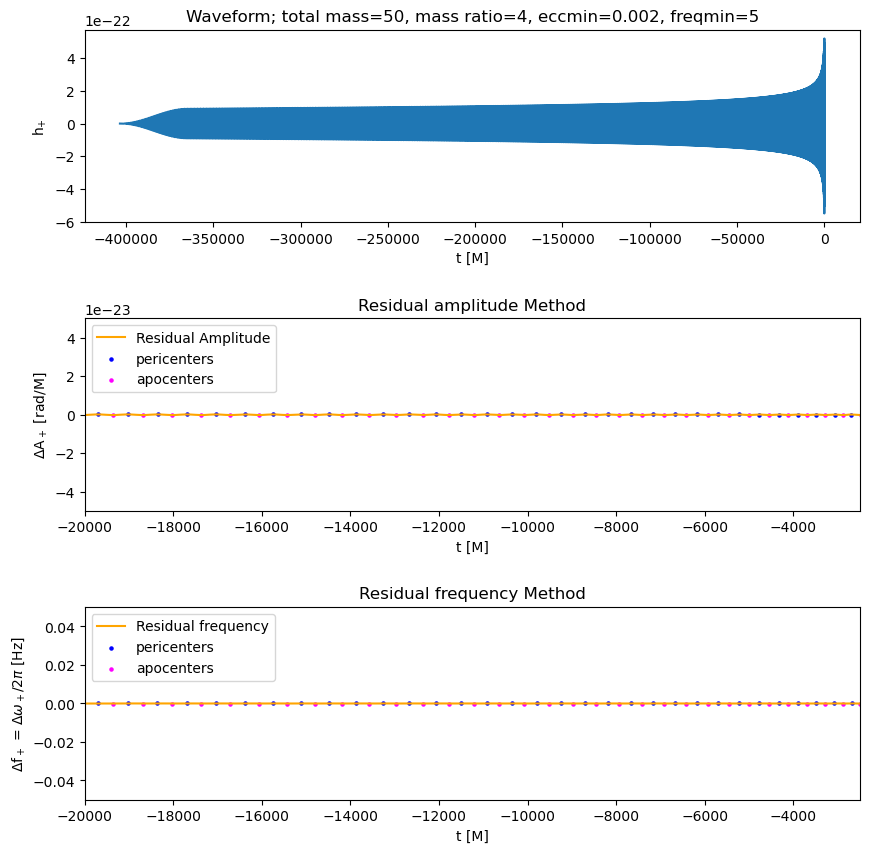

In [7]:
Residual_Freq_Amp_Method(50, 4, 0.002, 5)

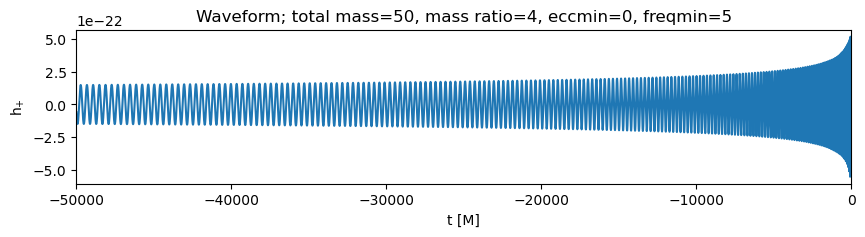

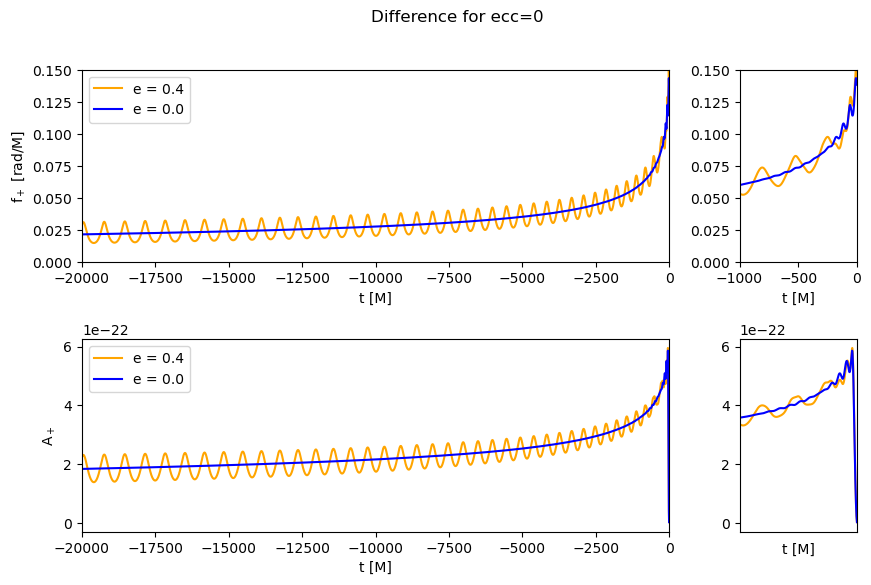

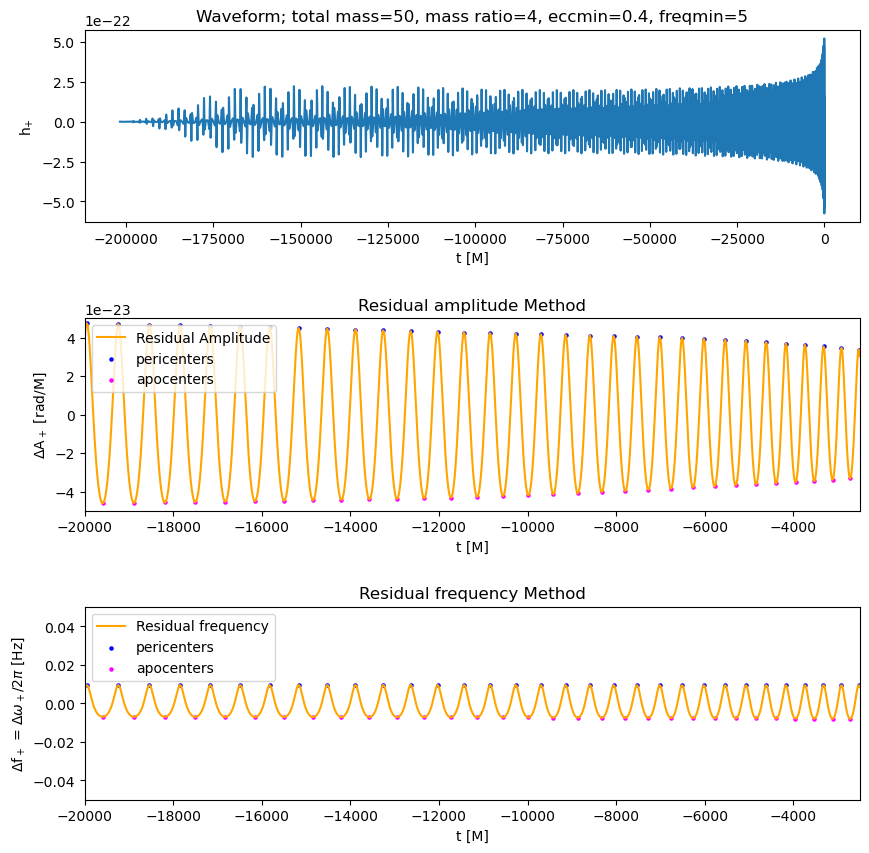

In [8]:
apos_time_freq, apos_freq, peris_time_freq, peris_freq, apos_time_amp, apos_amp, peris_time_amp, peris_amp, res_freq, res_amp = Residual_Freq_Amp_Method(50, 4, 0.4, 5)



In [258]:

def FrequencyFits_Method(total_mass, mass_ratio, eccmin, freqmin):
    # FREQUENCY FITS AND AMPLITUDE FITS METHOD

    # Pericenters and Apocenters of frequency and amplitude
    apos_time_freq, apos_freq, peris_time_freq, peris_freq, apos_time_amp, apos_amp, peris_time_amp, peris_amp, freq, amp, freq_times, amp_times = Freq_Amp_Method(total_mass, mass_ratio, eccmin, freqmin)

   
    def fit_func(t, f0, f1, t_merg):
        # Fit guess for frequency (reduced correlation)
        t_mid=t[(int(len(t)/2))]
        n = -f1*(t_merg - t_mid)/f0
        A = f0*(t_merg - t_mid)**(-n)
        return A*(t_merg - t)**n

    def fit_function(t, A, n, t_merg):
        # Fit guess for frequency
        return A*(t_merg - t)**n 

    # Fit the function for frequency apocenters and epicenters
    params_w_a, covariance_w_a = curve_fit(fit_function, apos_time_freq[5:-4], apos_freq[5:-4], p0 = [850, -0.3, 150])
    params_w_p, covariance_w_p = curve_fit(fit_function, peris_time_freq[5:-4], peris_freq[5:-4], p0 = [250, -0.3, 45])
    print("Fitted parameters w_apos; A:{}, t_merg:{}, n:{}".format(*params_w_a),
          "\nFitted parameters w_peris; A:{}, t_merg:{}, n:{}".format(*params_w_p))
    
    
    # Fit the function for amplitude apocenters and epicenters
    params_A_a, covariance_A_a = curve_fit(fit_function, apos_time_amp[:-5], apos_amp[:-5], p0 = [1e-21, -0.3, 330])
    params_A_p, covariance_A_p = curve_fit(fit_function, peris_time_amp[:-5], peris_amp[:-5], p0 = [5e-22, -0.3, 19])
    print("Fitted parameters A_apos; A:{}, t_merg:{}, n:{}".format(*params_A_a),
          "\nFitted parameters A_peris; A:{}, t_merg:{}, n:{}".format(*params_A_p))    

    # Fit on actual waveform for <w_22> and <A_22>
    params_A, covariance_A = curve_fit(fit_function, amp_times[:-10], amp[:-10], p0 = [1e-21, -0.3, 330])
    params_w, covariance_w = curve_fit(fit_function, freq_times[5:], freq[5:], p0 = [250, -0.3, 45])
    print("Fitted parameters A; A:{}, t_merg:{}, n:{}".format(*params_A),
          "\nFitted parameters w; A:{}, t_merg:{}, n:{}".format(*params_w)) 



    def U_fit(t, y, params_fit_a, params_fit_p):
        # Determine U_(t) for substraction of fit function
        
        fit_p = fit_function(t, *params_fit_p)
        U_p = np.zeros(len(y))

        fit_a = fit_function(t, *params_fit_a)
        U_a = np.zeros(len(y))

        for i in range(len(y)):
            U_p[i] = y[i] - fit_p[i]
            U_a[i] = -(y[i] - fit_a[i])

        return U_a, U_p, fit_a, fit_p

    # U_p(t) = w_22 - w_22^fit_p 
    U_w_a, U_w_p, fit_w_a, fit_w_p = U_fit(freq_times, freq, params_w_a, params_w_p)
    # U_a(t) = w_22 - w_22^fit_a
    U_A_a, U_A_p, fit_A_a, fit_A_p = U_fit(amp_times, amp, params_A_a, params_A_p)

    # U(t) = w_22 - w_22^fit and U(t) = A_22 - A_22^fit
    U_w, U_, fit_w, fit_ = U_fit(freq_times, freq, params_w, [1, 1, 1])
    U_A, U_, fit_A, fit_ = U_fit(amp_times, amp, params_A, [1, 1, 1])


    
    fig3, axs = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [5, 2, 5, 2]})
    plt.subplots_adjust(hspace=0.4)

    fig3.suptitle('Frequency/AmplitudeFits Method; total mass={}, mass ratio={}, eccmin={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin))

    # Fit for frequency
    axs[0].plot(amp_times, amp, color='orange')
    axs[0].plot(amp_times, fit_A_a, 'r--', label='fit apo: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params_A_a))
    axs[0].plot(amp_times, fit_A_p, 'b--', label='fit peri: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params_A_p))
    axs[0].scatter(peris_time_amp[:-5], peris_amp[:-5], color='blue', s=5 , label='pericenters')
    axs[0].scatter(apos_time_amp[:-5], apos_amp[:-5], color='magenta', s=5 , label='apocenters')
    axs[0].set_ylabel('A$_+$')
    axs[0].set_xlim(-6000, 0)
    # axs[0].set_ylim(1.8e-22, 2.0e-22)
    # axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('A$_+$')
    # axs[0].set_title('AmplitudeFits Method')

    # AmplitudeFits Method U(t)
    axs[1].plot(amp_times, U_A_p, label='U(t) = A$_{22}$ - A$_{22}^{fit_p}$', color='blue')
    axs[1].plot(amp_times, U_A_a, label='U(t) = -(A$_{22}$ - A$_{22}^{fit_a}$)', color='magenta')
    # axs[2].plot(amp_times, U_A_p, label='U(t) = -(A$_{22}$ - A$_{22}^{fit}$)', color='magenta')
    # axs[2].plot(amp_times, U_A_a, label='U(t) = -(A$_{22}$ - A$_{22}^{fit}$)', color='magenta')
    # axs[2].scatter(fit_amp_times_peris[pericenters_index_amp], peris_amp_diff, color='blue', s=5 , label='pericenters')
    # axs[2].scatter(fit_amp_times_apos[apocenters_index_amp], apos_amp_diff, color='magenta', s=5 , label='apocenters')
    axs[1].set_ylabel('$\Delta$A$_+$')
    axs[1].set_xlim(-18000, -14000)
    axs[1].set_ylim(-4e-24, 2e-24)
    # axs[1].set_xlabel('t [M]')
    axs[1].legend(loc='upper left')
    # axs[1].set_title('AmplitudeFits Method')

    # Fit for amplitude
    axs[2].plot(freq_times, freq, color='orange')
    axs[2].plot(freq_times, fit_w_p, 'b--', label='fit peri: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params_w_p))
    axs[2].plot(freq_times, fit_w_a, 'r--', label='fit apo: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params_w_a))
    # axs[1].plot(freq_times, fit_w, 'r--', label='fit w: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(params_w))
    axs[2].scatter(peris_time_freq[5:-5], peris_freq[5:-5], color='blue', s=5 , label='pericenters')
    axs[2].scatter(apos_time_freq[5:-5], apos_freq[5:-5], color='magenta', s=5 , label='apocenters')
    axs[2].set_xlim(-10000, 0)
    # axs[2].set_ylim([0.021, 0.025])
    # axs[2].set_xlabel('t [M]')
    axs[2].set_ylabel('f$_+$ = $\omega_+$/2$\pi$ [rad/M]')
    # axs[2].set_title('FrequencyFits Method')
    axs[2].legend(loc='upper left')


    # FrequencyFits Method U(t)
    axs[3].plot(freq_times, U_w_p, label = 'U(t) = w$_{22}$ - w$_{22}^{fit_p}$', color='blue')
    axs[3].plot(freq_times, U_w_a, label = 'U(t) = -(w$_{22}$ - w$_{22}^{fit_a}$)', color='magenta')
    # axs[3].plot(freq_times, U_w, label = 'U(t) = -(w$_{22}$ - w$_{22}^{fit}$)', color='magenta')
    # axs[3].scatter(fit_freq_times[fit_freq_pericenters_index], fit_freq_pericenters, color='blue', s=5 , label='pericenters')
    # axs[3].scatter(fit_freq_times[fit_freq_apocenters_index], fit_freq_apocenters, color='magenta', s=5 , label='apocenters')
    axs[3].set_ylabel('$\Delta$f$_+$ = $\Delta\omega_+$/2$\pi$ [rad/M]')
    axs[3].set_xlim(-18000, -14000)
    axs[3].set_ylim(-5e-4, 3e-4)
    axs[3].set_xlabel('t [M]')
    axs[3].legend(loc='upper left')
    # axs[3].set_title('FrequencyFits Method')



    
    figname = 'Freq_Amp_Fits_Method_e={}.png'.format(eccmin)
    fig3.savefig('Images/' + figname)


    return fit_w_a, fit_w_p, freq_times



Fitted parameters w_apos; A:1.373452415699763, t_merg:-0.44580194722642846, n:274.16537970361935 
Fitted parameters w_peris; A:0.5739843195793461, t_merg:-0.3090097159339886, n:64.03527851579376
Fitted parameters A_apos; A:3.360227698627861e-20, t_merg:-0.5291610993732816, n:4183.234924885464 
Fitted parameters A_peris; A:1.111890162625052e-21, t_merg:-0.15583649244848014, n:-244.52417728441586


/tmp/ipykernel_560/1095101930.py:17: RuntimeWarning: invalid value encountered in power
  return A*(t_merg - t)**n


Fitted parameters A; A:1.1066616294814974e-20, t_merg:-0.39894802791647277, n:3580.5720415375613 
Fitted parameters w; A:0.9194478239842461, t_merg:-0.38404612174331937, n:99.06885338735184


/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:435: RuntimeWarning: invalid value encountered in power
  return self._data ** other


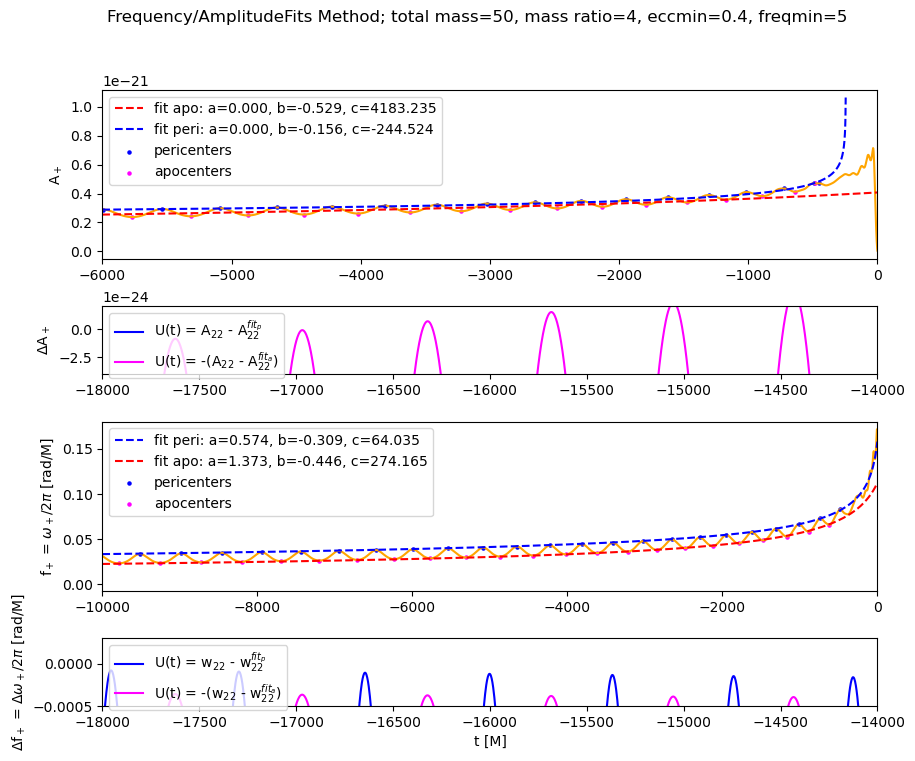

In [259]:
FrequencyFits_Method(50, 4, 0.4, 5)

plt.show()

Fitted parameters w_apos; A:0.7998156393389261, t_merg:-0.3644612920274322, n:176.49441031495186 
Fitted parameters w_peris; A:0.6887246107479108, t_merg:-0.351348255267234, n:79.46070810599986
Fitted parameters A_apos; A:2.1384657913627483e-21, t_merg:-0.24679596554158215, n:361.7162223082143 
Fitted parameters A_peris; A:2.044353382226575e-21, t_merg:-0.2425075961815622, n:266.5941844659263
Fitted parameters A; A:2.7643291704453145e-21, t_merg:-0.2715622530508352, n:671.8762110941066 
Fitted parameters w; A:0.7757715221066931, t_merg:-0.36172778201629646, n:136.16409926766414


(<pycbc.types.array.Array at 0x7f58983ce850>,
 <pycbc.types.array.Array at 0x7f58a0be4850>)

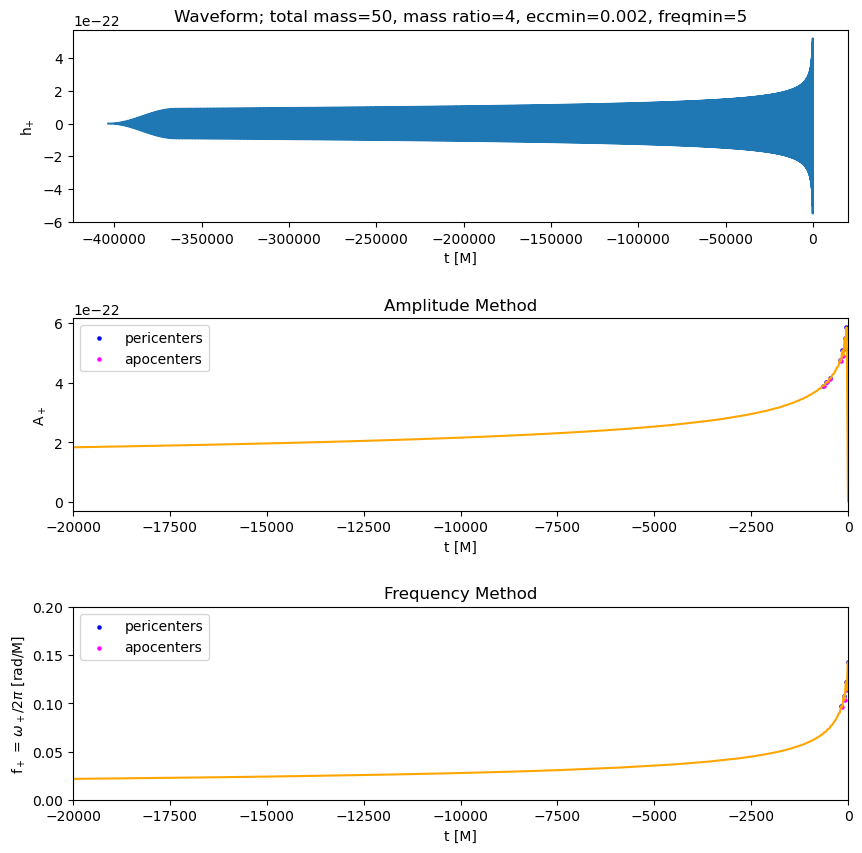

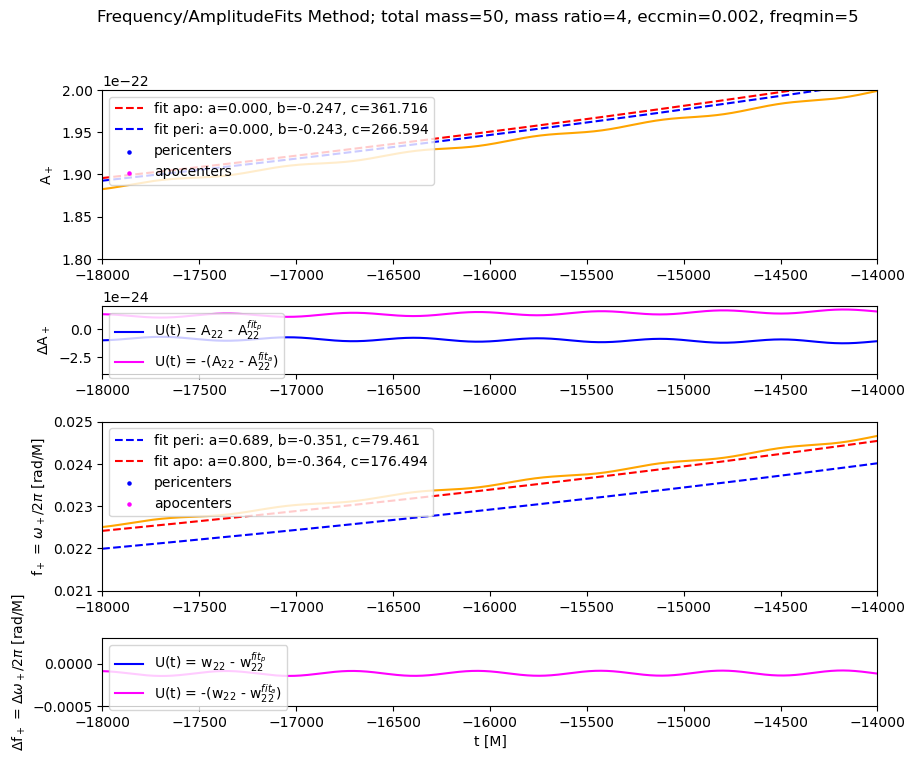

In [11]:
FrequencyFits_Method(50, 4, 0.002, 5)

# Finding eccentricity

In [260]:
# Eccentricity estimate 
def e_gw(w_p, w_a):

    # Frequency apos and peris at t_ref [rad/M]
    # w_p, w_a = w_p * 180/np.pi, w_a * 180/np.pi
    e_w = (np.sqrt(w_p) - np.sqrt(w_a)) / (np.sqrt(w_p) + np.sqrt(w_a))
    phi = np.arctan(( 1 - e_w**2 ) / 2*e_w)

    e_gw = np.cos(phi / 3) - np.sqrt(3)*np.sin(phi / 3)

    return e_gw
        

Fitted parameters w_apos; A:1.373452415699763, t_merg:-0.44580194722642846, n:274.16537970361935 
Fitted parameters w_peris; A:0.5739843195793461, t_merg:-0.3090097159339886, n:64.03527851579376
Fitted parameters A_apos; A:3.360227698627861e-20, t_merg:-0.5291610993732816, n:4183.234924885464 
Fitted parameters A_peris; A:1.111890162625052e-21, t_merg:-0.15583649244848014, n:-244.52417728441586


/tmp/ipykernel_560/1095101930.py:17: RuntimeWarning: invalid value encountered in power
  return A*(t_merg - t)**n


Fitted parameters A; A:1.1066616294814974e-20, t_merg:-0.39894802791647277, n:3580.5720415375613 
Fitted parameters w; A:0.9194478239842461, t_merg:-0.38404612174331937, n:99.06885338735184


/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:435: RuntimeWarning: invalid value encountered in power
  return self._data ** other


[-2.60422763e+05 -2.60420780e+05 -2.60418798e+05 ... -4.95667747e+00
 -2.97400709e+00 -9.91336712e-01] [0.94284973 0.9428498  0.94284986 ... 0.97633619 0.9759243  0.97549531]


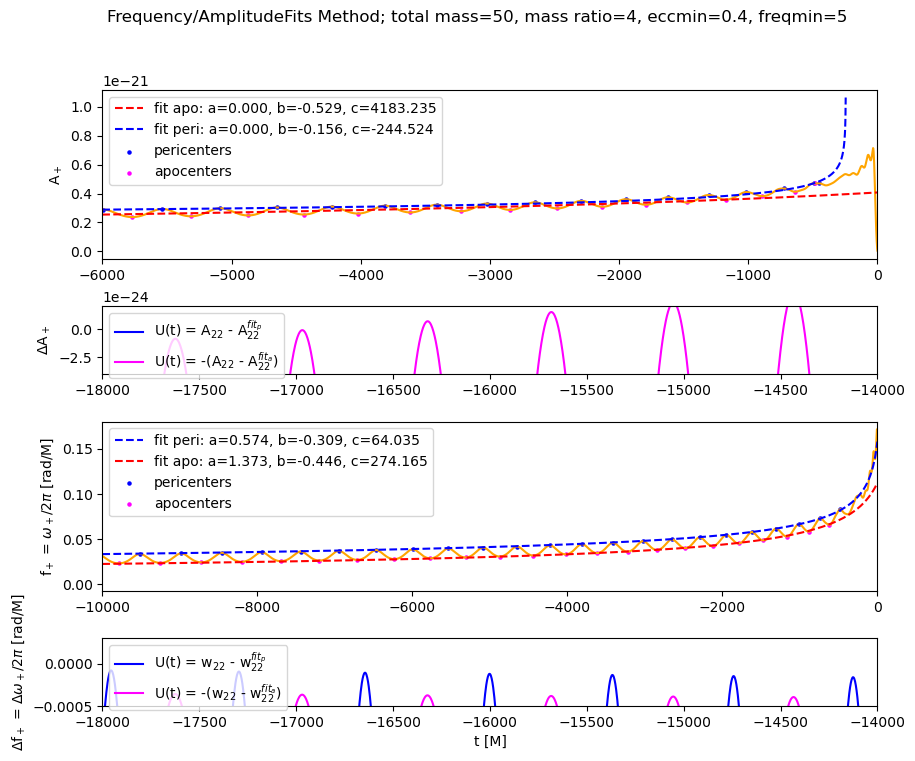

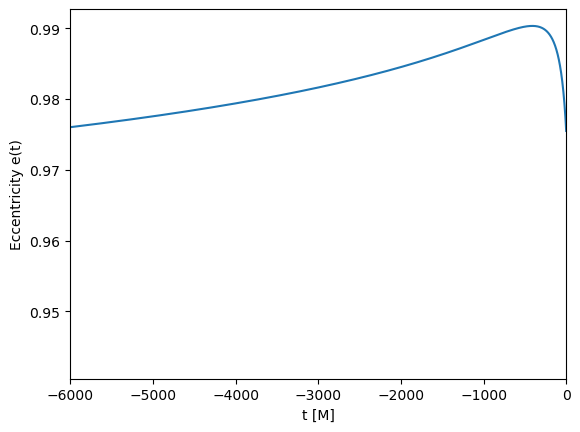

In [261]:


fit_w_a, fit_w_p, freq_times = FrequencyFits_Method(50, 4, 0.4, 5)
e__gw = e_gw(fit_w_p, fit_w_a)


fig_e = plt.figure()
print(freq_times, e__gw)

plt.plot(freq_times, e__gw)
plt.xlabel('t [M]')
plt.ylabel('Eccentricity e(t)')
plt.xlim(-6000, 0)
# plt.ylim(0, 1)
plt.show()

# Surrogate modeling

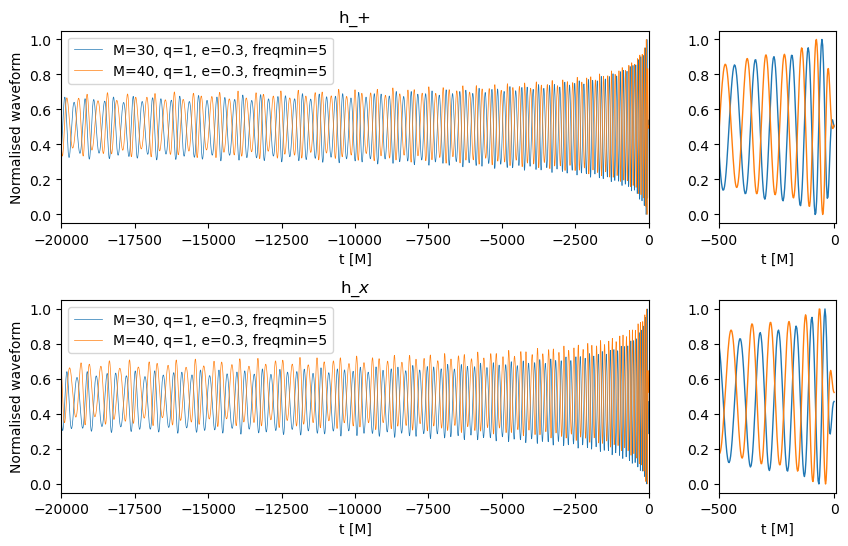

In [25]:
def normalize_array(arr):
    min_val = min(arr)
    max_val = max(arr)
    
    normalized_arr = [(x - min_val) / (max_val - min_val) for x in arr]
    
    return normalized_arr

def Normalised_wf(total_mass, mass_ratio, eccmin, freqmin):
    # Normalised and mass independant waveforms
    hp_TS, hc_TS = SimInspiral(total_mass, mass_ratio, eccmin, freqmin)
    
    norm_hp_TS = normalize_array(hp_TS)
    norm_hc_TS = normalize_array(hc_TS)
    # norm_hp_TS = [x//(lal.MTSUN_SI * total_mass ) for x in norm_hp_TS]
    # norm_hc_TS = [x//(lal.MTSUN_SI * total_mass ) for x in norm_hc_TS]
    
    
    # Convert units from seconds to M
    hp_times = -hp_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass ) 
    hc_times = -hc_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass )



    
    axs[0][0].plot(hp_times, norm_hp_TS, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    axs[0][0].set_ylabel('Normalised waveform')
    axs[0][0].set_xlim(-20000, 0)
    # axs[0][0].set_ylim(-6e-22, 6e-22)
    axs[0][0].set_xlabel('t [M]')
    axs[0][0].legend(loc='upper left')
    axs[0][0].set_title('h_$+$')
    
    axs[0][1].plot(hp_times, norm_hp_TS, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=1)
    axs[0][1].set_xlim(-500, 10)
    # axs[0][1].set_ylim(-6e-22, 6e-22)
    axs[0][1].set_xlabel('t [M]')

    axs[1][0].plot(hc_times, norm_hc_TS, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    axs[1][0].set_ylabel('Normalised waveform')
    axs[1][0].set_xlim(-20000, 0)
    # axs[0][0].set_ylim(-6e-22, 6e-22)
    axs[1][0].set_xlabel('t [M]')
    axs[1][0].legend(loc='upper left')
    axs[1][0].set_title('h_$x$')
    
    axs[1][1].plot(hc_times, norm_hc_TS, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=1)
    axs[1][1].set_xlim(-500, 10)
    # axs[0][1].set_ylim(-6e-22, 6e-22)
    axs[1][1].set_xlabel('t [M]')

    return norm_hp_TS, norm_hc_TS

# # Different mass ratio
# fig_q, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1]})
# plt.subplots_adjust(hspace=0.4)

# for mass_ratio in [1, 2]:
#     Normalised_wf(40, mass_ratio, 0.4, 5)
    
    
# different eccmin
fig_ecc, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1]})
plt.subplots_adjust(hspace=0.4)

# for ecc_min in [0.2, 0.6]:
#     Normalised_wf(40, 1, ecc_min, 5)

for mass in [30, 40]:
    Normalised_wf(mass, 1, 0.3, 5)

plt.show()



In [ ]:
def form_wf_database(total_mass, mass_ratio, ecc_range, freqmin):
    hp_TS_database, hc_TS_database = [], []
    
    for i, eccmin in enumerate(ecc_range): 
        # Normalised and mass independant waveforms
        hp_TS, hc_TS = SimInspiral(total_mass, mass_ratio, eccmin, freqmin)
        
        norm_hp_TS = normalize_array(hp_TS)
        norm_hc_TS = normalize_array(hc_TS)

        hp_TS_database.append(norm_hp_TS)
        hc_TS_database.append(norm_hc_TS)

    return hp_TS_database, hc_TS_database

wf_database_ecc = form_wf_database(50, 4, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 5)

In [ ]:
import numpy as np

def gram_schmidt(A):
    """Classical Gram-Schmidt orthogonalization."""
    Q, _ = np.linalg.qr(A)
    return Q

def compute_reduced_basis(waveforms):
    """Compute the reduced basis using the Classical Gram-Schmidt procedure."""
    n, num_waveforms = waveforms.shape
    reduced_basis = np.zeros((n, num_waveforms))

    for i in range(num_waveforms):
        # Apply Gram-Schmidt to orthogonalize the current waveform with respect to the previous ones
        reduced_basis[:, :i+1] = gram_schmidt(waveforms[:, :i+1])

    return reduced_basis

# Example usage:
# Generate a random dataset with 5 waveforms of length 10

np.random.seed(42)
example_waveforms = np.random.rand(10, 5)

# Compute the reduced basis
reduced_basis = compute_reduced_basis(example_waveforms)

# Print the example waveforms and the resulting reduced basis
print("Example Waveforms:")
print(example_waveforms)

print("\nReduced Basis:")
print(reduced_basis)

# Spherical harmonics

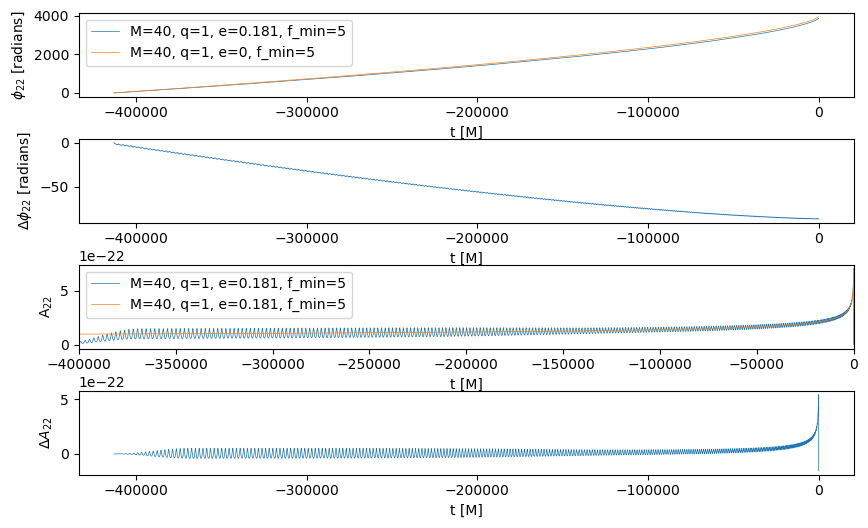

In [5]:

Plot_phase_amplitude(40, 1, 0.181, 5)

plt.show()

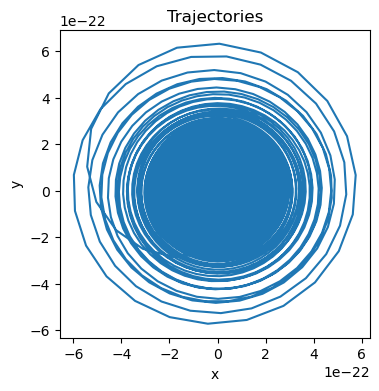

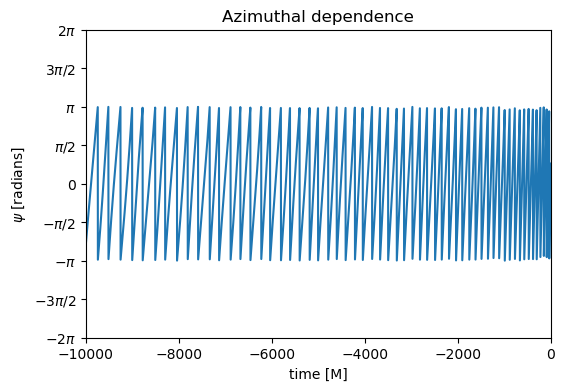

In [200]:
from matplotlib.ticker import FuncFormatter, MultipleLocator


def get_angles(A, azimuthal, inclination = 0.):
    inclination = inclination + np.pi/2
    
    x = A * np.cos(azimuthal) * np.sin(inclination)
    y = A * np.sin(azimuthal) * np.sin(inclination)
    z = A * np.cos(inclination)


    phi = np.arctan2(y, x) # Azimutal angle
    theta = inclination # Polar angle

    return x, y, phi, theta

phase, D_phase, amp, hp_times, phase_circ = phase_amplitude_wf(40, 2, 0.3, 5)
x, y, phi, theta = get_angles(amp, phase)


fig_trajectory = plt.figure(figsize = (4, 4))

plt.plot(x, y)
plt.title('Trajectories')
# plt.xlim(-10000, 0)
# plt.ylim(-1, 1)
plt.xlabel('x')
plt.ylabel('y')


fig_azimuthal = plt.figure(figsize = (6,4))

plt.title('Azimuthal dependence')
plt.plot(hp_times, phi)
plt.ylim((-2*np.pi, 2*np.pi))
plt.xlim((-10000, 0))

ticks = np.arange(-2 * np.pi, 2 * np.pi + np.pi / 2, np.pi / 2)
tick_labels = ['$-2\pi$', '$-3\pi/2$', '$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']

plt.yticks(ticks, tick_labels)
plt.xlabel('time [M]')
plt.ylabel('$\psi$ [radians]')


plt.show()

/home/suzannelexmond/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-1.0, 1.0)

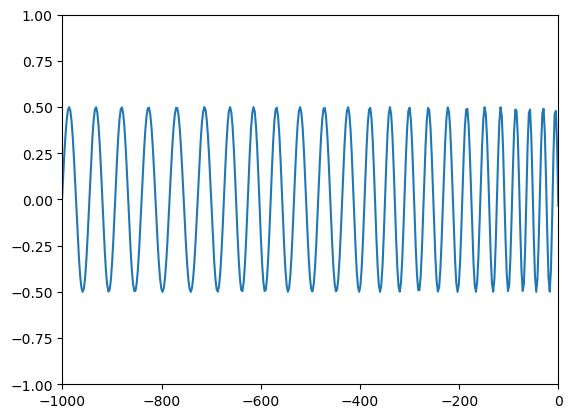

In [207]:
from scipy.special import sph_harm

def get_spherical_modes(total_mass, mass_ratio, eccmin, freqmin, m, l):

    phase, D_phase, amp, hp_times, phase_circ = phase_amplitude_wf(total_mass, mass_ratio, eccmin, freqmin)
    x, y, phi, theta = get_angles(amp, phase)

    # h_ml = sph_harm(theta, phi, m, l)
    A_22 = 0.5*(1 + np.cos(theta))**2
    h_ml = A_22*np.exp(complex(0, 1)*m*phi)
    

    return h_ml, hp_times


h_22, hp_times = get_spherical_modes(40, 2, 0.3, 5, 2, 2)

fig_modes = plt.figure()

plt.plot(hp_times, h_22)
plt.xlim(-1000, 0)
plt.ylim(-1, 1)




# Building the surrogate model

In [88]:
def SimInspiral_M_independent(total_mass, mass_ratio, eccmin, freqmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    """ Input: total_mass in M_sun, mass_ratio >= 1 (mass1 > mass2)
        Output: 
    
    """

    mass1 = total_mass/((1/mass_ratio) + 1)
    mass2 = total_mass - mass1

    hp_TS, hc_TS = SimInspiral(mass1, mass2, eccmin, freqmin)

    
    hp_TS_over_M = hp_TS/total_mass
    hc_TS_over_M = hc_TS/total_mass


    return hp_TS_over_M, hc_TS_over_M

def plot_Siminspiral_M_indp(M_total, mass_ratio, eccmin):
    """ Input: M_total: A list of total masses in solar mass, 
        mass_ratio: A list of mass ratio's for 0 <= q <= 1, 
        eccmin: A list of eccentricities for 0 <= e <= 1
    """
    fig_M = plt.figure(figsize=(8,3))
        
    for total_mass in M_total:
        for ratio in mass_ratio:
            for eccentricity in eccmin:

                start = timer()

                hp_TS_over_M, hc_TS_over_M = SimInspiral_M_independent(total_mass, ratio, eccentricity, freqmin=50/total_mass)
                t_over_M = -hp_TS_over_M.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

                plt.plot(t_over_M, hp_TS_over_M, label = 'M = {} $(M_\odot)$, q = {}, e = {}'.format(total_mass, ratio, eccentricity))
                plt.xlim([-7e3, 5e2])
                plt.legend(loc = 'upper left')
                plt.xlabel('t/M')
                plt.ylabel('Normalized h$_{+}$/M')
                plt.title('Waveform in units of mass')

                print("time GPU:", (timer()-start)/60, ' minutes')
                print('Strain is calculated')
            
    figname = 'total mass = {}, mass ratio = {}, ecc = {}.png'.format(M_total, mass_ratio, eccmin)
    # fig.savefig('Images/' + figname)
    print('fig is saved')
    plt.show()


time GPU: 2.2874326449998383  minutes
Strain is calculated
fig is saved


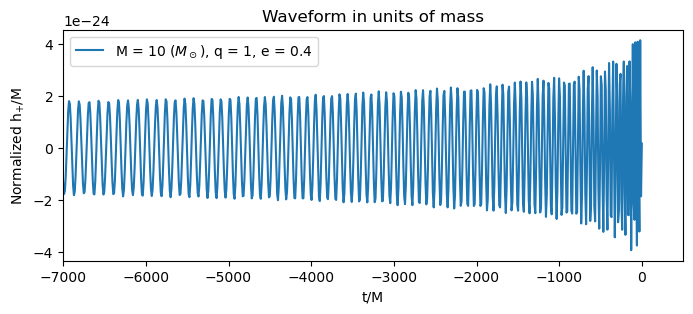

In [89]:
plot_Siminspiral_M_indp([10], [1], [0.4])

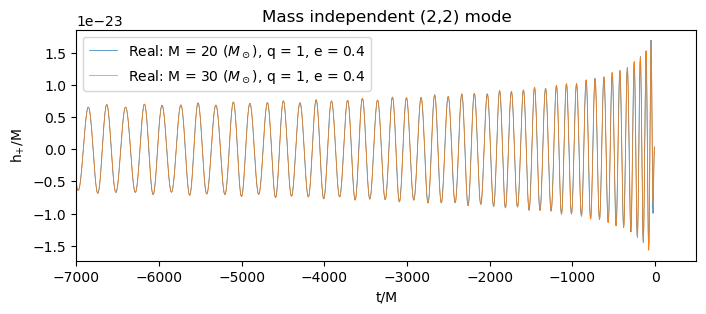

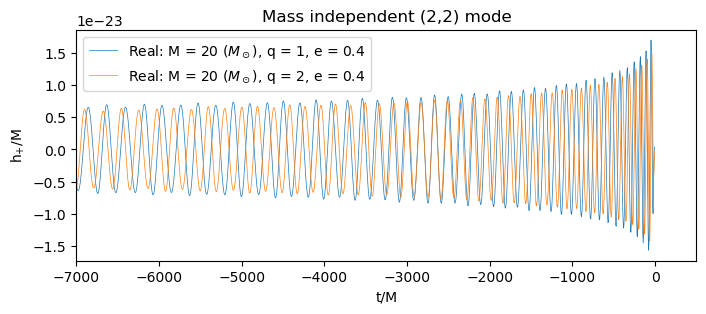

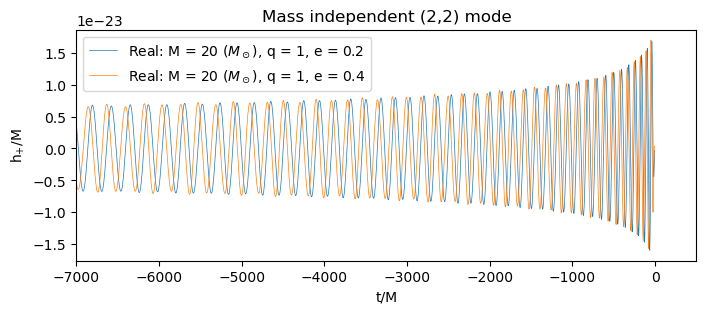

In [21]:
plot_Siminspiral_M_indp([20, 30], [1], [0.4])
plot_Siminspiral_M_indp([20], [1, 2], [0.4])
plot_Siminspiral_M_indp([20], [1], [0.2, 0.4])
plt.show()

NameError: name 'total_mass' is not defined

In [8]:
def phase_amplitude_wf(total_mass, mass_ratio, eccmin, freqmin):
    
    hp_TS, hc_TS = SimInspiral(total_mass, mass_ratio, eccmin, freqmin)
    

    # Convert units from seconds to M
    hp_times = -hp_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass ) 

    amp = waveform.utils.amplitude_from_polarizations(hp_TS, hc_TS)
    phase = waveform.utils.phase_from_polarizations(hp_TS, hc_TS)


    # Zero eccentricity
    hp_TS_circ, hc_TS_circ = SimInspiral(total_mass, mass_ratio, 1e-10, 5)
    
    amp_circ = waveform.utils.amplitude_from_polarizations(hp_TS_circ, hc_TS_circ)
    phase_circ = waveform.utils.phase_from_polarizations(hp_TS_circ, hc_TS_circ) 
    hp_circ_times = -phase_circ.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

    # Correct or longer time till merger in circulair case
    diff = phase_circ[len(phase_circ) - len(phase)]
    phase_circ = phase_circ - diff
    phase_circ = phase_circ[len(phase_circ) - len(phase):]
    

    # Phase difference 
    D_phase = np.zeros(len(phase))

    for i in range(len(hp_times)):
        D_phase[i] = phase[i] - phase_circ[i]

    D_amp = np.zeros(len(amp))

    for i in range(len(hp_times)):
        D_amp[i] = amp[i] - amp_circ[i]
    
    return phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times


def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, freqmin):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, freqmin)
    
    
    fig_phase_amp, axs = plt.subplots(4, 1, figsize=(10, 6))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    axs[0].plot(hp_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_ylim(2000, 4000)
    axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')


    # # axs[1].plot(hp_circ_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[1].plot(hp_circ_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # axs[1].set_ylabel('$\phi$ [radians]')
    # # axs[0].set_xlim(-10000, 0)
    # # axs[0].set_ylim(2000, 4000)
    # axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')
    
    axs[1].plot(hp_times, D_phase, linewidth=0.6)
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')

    # axs[2].plot(hp_times, D_phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[2].set_ylabel('$\Delta\phi$ [radians]')
    # axs[2].set_xlim(-400000, -380000)
    # axs[2].set_ylim(-1, 10)
    # axs[2].set_xlabel('t [M]')
    # axs[2].legend(loc='upper left')
    
    
    axs[2].plot(hp_times, amp, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    axs[2].plot(hp_circ_times, amp_circ, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    axs[2].set_ylabel('A$_{22}$')
    axs[2].set_xlim(-400000, 0)
    # axs[0][0].set_ylim(-6e-22, 6e-22)
    axs[2].set_xlabel('t [M]')
    axs[2].legend(loc='upper left')

    

    # axs[2].plot(phase, amp, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[2].set_ylabel('Amplitude')
    # # axs[1].set_xlim(-20000, 0)
    # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # axs[2].set_xlabel('Phase [radians]')
    # axs[2].legend(loc='upper left')


    axs[3].plot(hp_times, D_amp, linewidth=0.5)
    axs[3].set_ylabel('$\Delta A_{22}$')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[3].set_xlabel('t [M]')
    
    


[ 0.         -0.04300817 -0.03971997 -0.03641181 -0.0330832 ] [0.         0.014523   0.02904602 0.04356907 0.05809216] [ 0.         -0.05753116 -0.06876599 -0.07998089 -0.09117535]


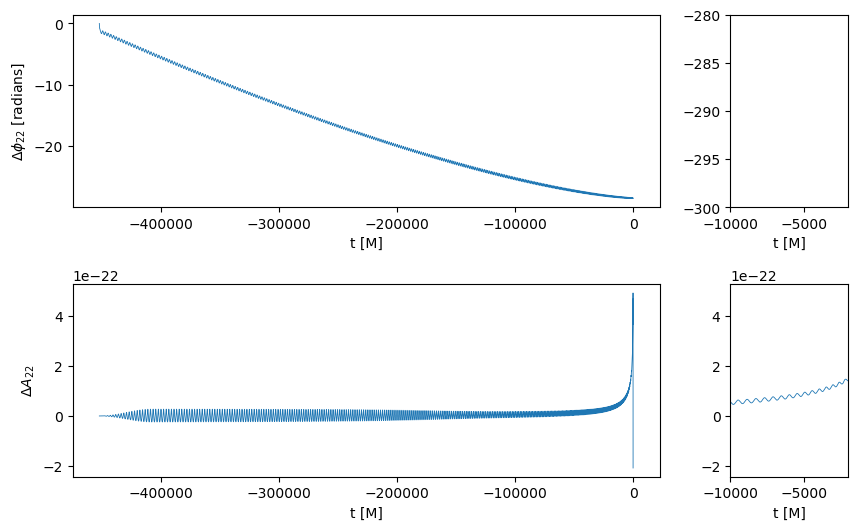

In [13]:
def phase_amp_diff(total_mass, mass_ratio, eccmin, freqmin):
    
    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, freqmin)
    print(phase[0:5], phase_circ[0:5], D_phase[0:5])
    
    fig_change, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1]})
    plt.subplots_adjust(hspace=0.4)
    
    axs[0][0].plot(hp_times, D_phase, linewidth=0.6)
    axs[0][0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0][0].set_xlabel('t [M]')
    
    axs[0][1].plot(hp_times, D_phase, linewidth=0.6)
    axs[0][1].set_xlim(-10000, -2000)
    axs[0][1].set_ylim(-300, -280)
    axs[0][1].set_xlabel('t [M]')
    
    axs[1][0].plot(hp_times, D_amp, linewidth=0.6)
    axs[1][0].set_ylabel('$\Delta A_{22}$')
    axs[1][0].set_xlabel('t [M]')
    
    axs[1][1].plot(hp_times, D_amp, linewidth=0.6)
    axs[1][1].set_xlim(-10000, -2000)
    axs[1][1].set_xlabel('t [M]')

plt.show()

phase_amp_diff(40, 1, 0.1, 5)